# Demo


In [8]:
import numpy as np
import pandas as pd
import time
import scipy as sp
import scipy.sparse
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
from bayesbridge import BayesBridge, RegressionModel, RegressionCoefPrior
from bayesbridge import HorseshoePrior
from bayesbridge.prior.transfer_learning_helper import get_informed_prior
from simulate_data import simulate_design, simulate_outcome
from util import mcmc_summarizer

## BayesBridge supports both dense (numpy array) and sparse (scipy sparse matrix) design matrices.

In [10]:
n_obs, n_pred = 10 ** 4, 10 ** 3

X = simulate_design(
    n_obs, n_pred, 
    binary_frac=.9,
    binary_pred_freq=.2,
    shuffle_columns=True,
    format_='sparse',
    seed=111
)

In [11]:
beta_true = np.zeros(n_pred)
beta_true[:5] = 1.5
beta_true[5:10] = 1.
beta_true[10:15] = .5

n_trial = np.ones(X.shape[0]) # Binary outcome.
y = simulate_outcome(
    X, beta_true, intercept=0., 
    n_trial=n_trial, model='logit', seed=1
)

In [12]:
X.shape

(10000, 1000)

In [14]:
y[0].shape

(10000,)

## load in JH data

In [1]:
import pickle

In [15]:
with open('./X_sparse_matrix_jhu.pickle', 'rb') as f:
    X_sparse_matrix = pickle.load(f)

with open('./y_vector_jhu.pickle', 'rb') as f:
    y_outcome = pickle.load(f)

In [16]:
X_sparse_matrix

<2035x17909 sparse matrix of type '<class 'numpy.float64'>'
	with 939046 stored elements in Compressed Sparse Row format>

In [22]:
X_sparse_matrix.shape

(2035, 17909)

In [25]:
n_trial = np.ones(len(y_outcome))
y = (y_outcome,n_trial)

In [23]:
len(n_trial)

2035

In [19]:
len(y_outcome)

2035

## Horseshoe prior

In [38]:
concept_relation_path = "~/Documents/github/run-bayes-bridger-on-pmap-data/concept_relation_hopkins_pharm_coef_dist.csv"
concept_relationship = pd.read_csv(concept_relation_path, header =0, index_col=0)

In [41]:
sigma_sq_ave_list = np.array([0.1, 0.5, 1, 2])
sigma_sq_db_list = np.array([0.1, 0.5, 1, 2])
r_list = np.array([.001, 0.01, 0.1, 1, 10, 100])
covar_index = concept_relationship.covaraiteIndex_jh
mu_beta_a_est = concept_relationship.relative_coef_est
dist = concept_relationship.dist

In [63]:
# initiate the skew_mean and skew_sd as a vector of 0s the same size as X
skew_mean, skew_sd = np.zeros(shape=X_sparse_matrix.shape[1]), np.ones(shape=X_sparse_matrix.shape[1])
skew_mean[covar_index-1], skew_sd[covar_index-1] = \
    get_informed_prior(mu_beta_a_est, r_list[0], dist, 1, 0.25)

{'whiskers': [<matplotlib.lines.Line2D at 0x2811081f0>,
 'caps': [<matplotlib.lines.Line2D at 0x281108610>,
 'boxes': [<matplotlib.lines.Line2D at 0x2810fbf10>],
 'medians': [<matplotlib.lines.Line2D at 0x281108b50>],
 'fliers': [<matplotlib.lines.Line2D at 0x281108df0>],
 'means': []}

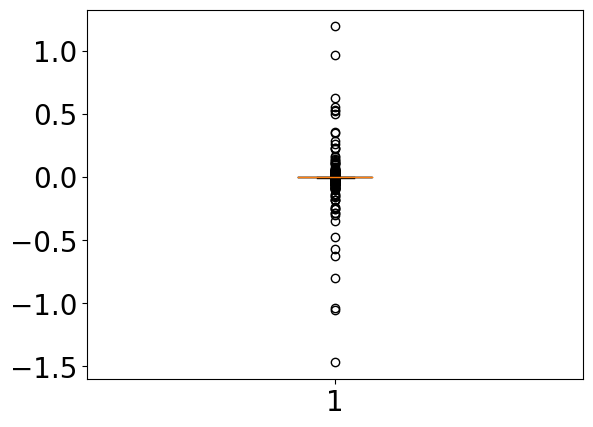

In [64]:
plt.boxplot(skew_mean)

{'whiskers': [<matplotlib.lines.Line2D at 0x281164d30>,
 'caps': [<matplotlib.lines.Line2D at 0x281176280>,
 'boxes': [<matplotlib.lines.Line2D at 0x177d58d90>],
 'medians': [<matplotlib.lines.Line2D at 0x2811767c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x281176a60>],
 'means': []}

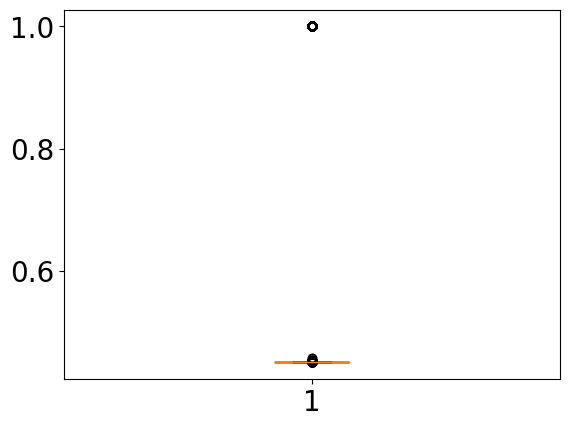

In [65]:
plt.boxplot(skew_sd)

In [26]:
model = RegressionModel(
    y, X_sparse_matrix, family='logit',
    add_intercept=True, center_predictor=True,
        # Do *not* manually add intercept to or center X.
)

prior = HorseshoePrior(
    n_fixed_effect=0,
    sd_for_intercept=float('inf'),
    sd_for_fixed_effect=1,
    regularizing_slab_size=2.,
    skew_mean=skew_mean,
    skew_sd=skew_sd,
    global_scale_prior=None
)

bridge = BayesBridge(model, prior)

NameError: name 'skew_mean' is not defined

### if the data is centered

In [27]:
model = RegressionModel(
    y, X_sparse_matrix, family='logit',
    add_intercept=True, center_predictor=True,
        # Do *not* manually add intercept to or center X.
)

prior = HorseshoePrior(
    n_fixed_effect=0,
    sd_for_intercept=float('inf'),
    sd_for_fixed_effect=1,
    regularizing_slab_size=2.,
    skew_mean=0.,
    skew_sd=1.,
    global_scale_prior=None
)

bridge = BayesBridge(model, prior)

## Run the Gibbs sampler.

In [28]:
samples, mcmc_info = bridge.gibbs(
    n_iter=250, n_burnin=0, thin=1, 
    init={'global_scale': .01},
    coef_sampler_type='cg',
    seed=111
)

/Users/gracexd/Documents/github/bayes-bridge-dev/bayesbridge/gibbs_util.py:69: UserWarning: Sampler has not been optimized for 'small n' problem.


Check convergence by looking at the traceplot for posterior log-density.

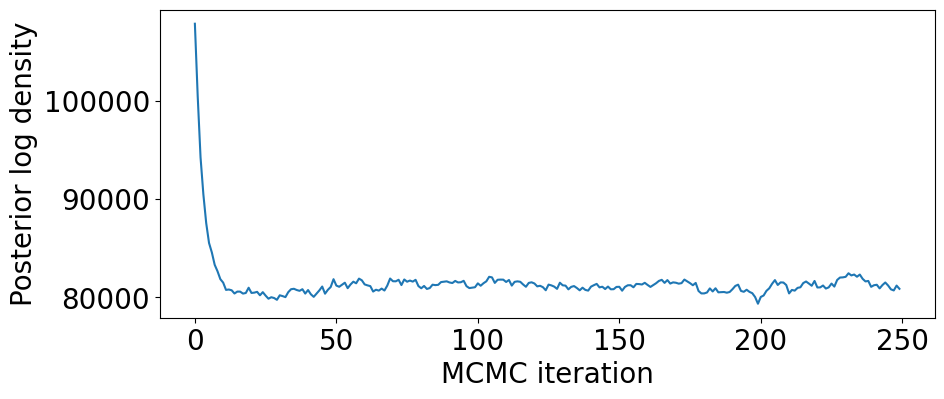

In [29]:
plt.figure(figsize=(10, 4))
plt.rcParams['font.size'] = 20

plt.plot(samples['logp'])
plt.xlabel('MCMC iteration')
plt.ylabel('Posterior log density')
plt.show()

## Restart MCMC from the last iteration with 'gibbs_resume()'.

In [30]:
samples, mcmc_info = bridge.gibbs_resume(
    mcmc_info, n_add_iter=250
)

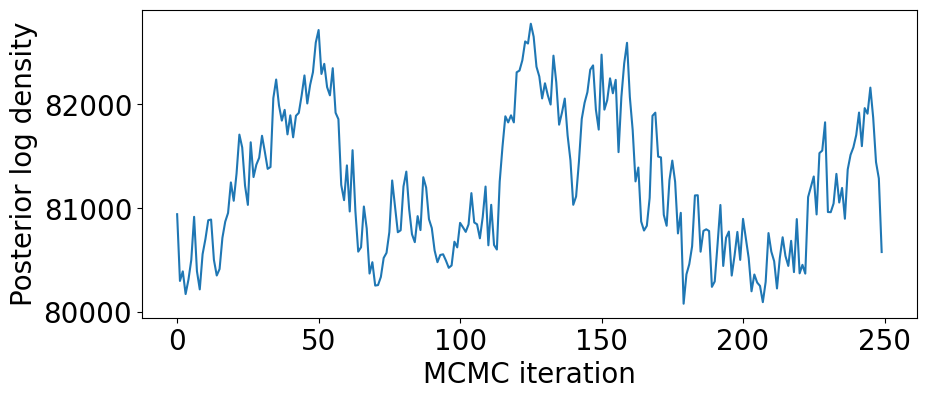

In [31]:
plt.figure(figsize=(10, 4))
plt.rcParams['font.size'] = 20

plt.plot(samples['logp'])
plt.xlabel('MCMC iteration')
plt.ylabel('Posterior log density')
plt.show()

Add more samples (while keeping the previous ones) with 'merge=True'.

In [32]:
samples, mcmc_info = bridge.gibbs_resume(
    mcmc_info, n_add_iter=750, merge=True, prev_samples=samples
)
coef_samples = samples['coef'][1:, :] # Extract all but the intercept

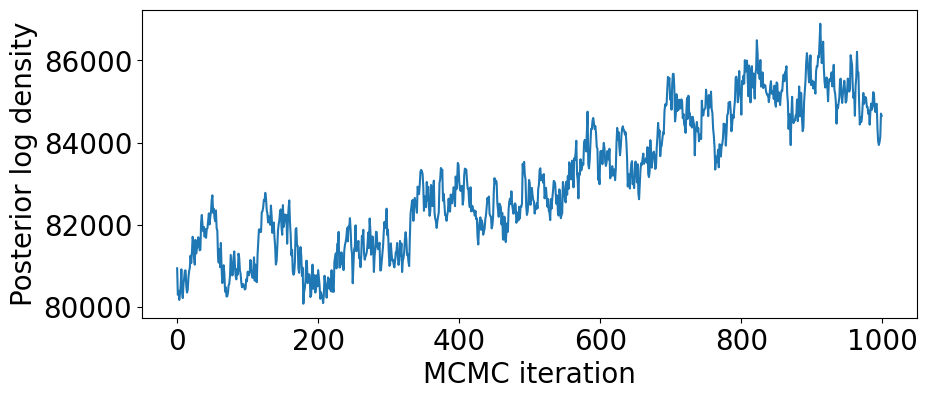

In [33]:
plt.figure(figsize=(10, 4))
plt.rcParams['font.size'] = 20

plt.plot(samples['logp'])
plt.xlabel('MCMC iteration')
plt.ylabel('Posterior log density')
plt.show()

## Check mixing of regression coefficients and their posterior marginals.

Typically the convergence is quick and mixing of the regression coefficients is adequate.

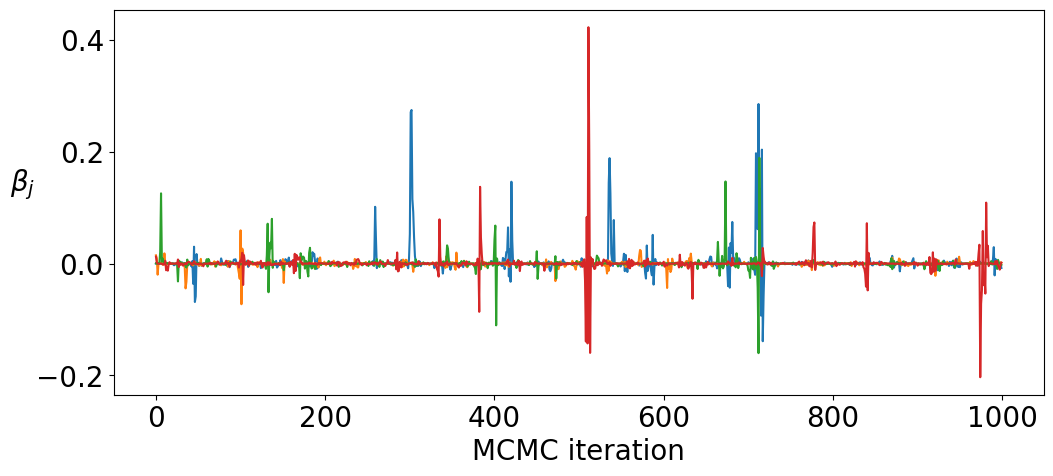

In [34]:
plt.figure(figsize=(12, 5))
plt.rcParams['font.size'] = 20

plt.plot(coef_samples[[0, 5, 10, 15], :].T)
plt.xlabel('MCMC iteration')
plt.ylabel(r'$\beta_j$', rotation=0, labelpad=10)
plt.show()

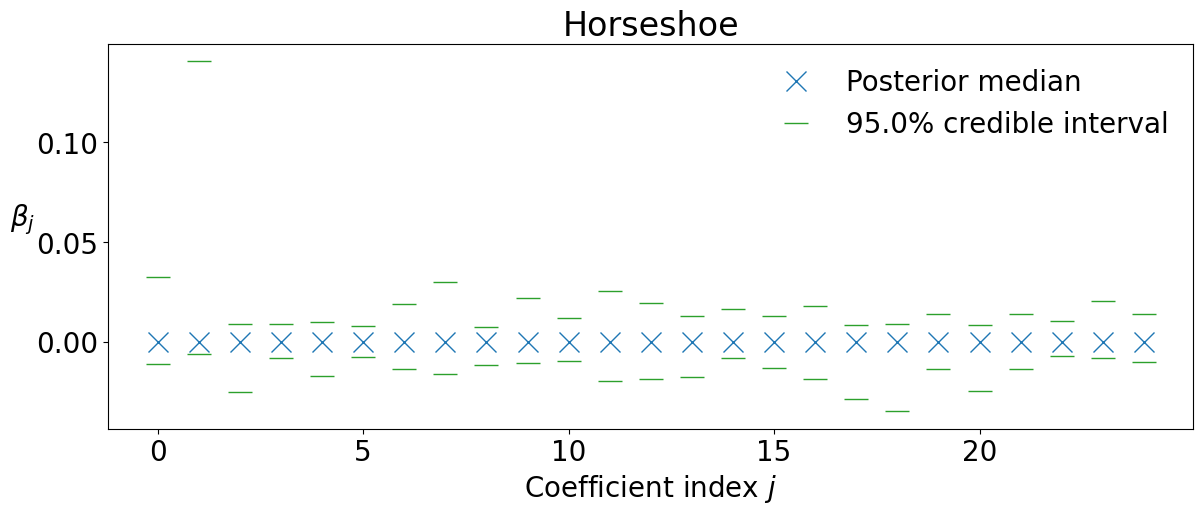

In [36]:
plt.figure(figsize=(14, 5))
plt.rcParams['font.size'] = 20

n_coef_to_plot = 25

mcmc_summarizer.plot_conf_interval(
    coef_samples, conf_level=.95, 
    n_coef_to_plot=n_coef_to_plot, marker_scale=1.4
);
# plt.plot(
#     beta_true[:n_coef_to_plot], '--', color='tab:orange',
#     label='True value'
# )
plt.title('Horseshoe')
plt.xlabel(r'Coefficient index $j$')
plt.ylabel(r'$\beta_j$', rotation=0, labelpad=10)
plt.xticks([0, 5, 10, 15, 20])
plt.legend(frameon=False)

plt.show()